# EED mKO vs WT - effect on H3K9me3

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

rs = np.random.RandomState()
rs.seed(42)

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/6_Preimplantation.EED_mKO_experiments.part6.effects_of_treatments_on_DamOnly_and_H3K9me3/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 100000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = HOME + 'projects/preimplantation/combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

# DamID file names
COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'
LADFN = '../../combining_all_data/data/damid_LADs/FR230814.all_DamID.LAD_calls.{construct}.{stage}.{treatment}.{genotype}.bed.gz'

ALLELEFILTFN = '../../combining_all_data/data/damid_allelic_filter/FR230814.allelic_filter_based_on_visibility_and_bias.{genotype}.binsize_{binsize:d}.hdf5'

# DamID mappability
MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# Gene information
GENESFN = HOME + 'references/mouse/mm10/genomic_element_info/FR200630.BioMart.mm10.all_genes.top_transcripts.txt.gz'
PARKFN = HOME + 'projects/preimplantation/DRA001066/data/tables/FR200923.Park_clusters_by_Ensembl_ID.tsv'

# Repeat information
REPEATFN = HOME + 'references/mouse/mm10/repeat_masker/mm10.RepeatMasker.txt.gz'

# 1. Loading our own data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## 1.1 Loading samplesheet

In [6]:
stage_order = ['zygote', '2cell', '8cell', 'mESC']
treatment_order = ['no_treatment', 'EED_ctrl', 'EED_mKO', 'Lap2b', 'Cbx7(CD)-Lap2b']
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t')
anno = anno[anno['construct'].isin(['Lmnb1', 'Cbx1(CD)', 'untethered'])].reset_index(drop=True)
anno = anno[anno['stage'].isin(stage_order)]
anno = anno[anno.cellcount == 1]
anno = anno[anno.treatment.isin(treatment_order)]
anno = anno.set_index('damid_name')
anno = anno[anno.DamID_PASS]

In [8]:
anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']).size()

fusion_construct  stage   genotype                treatment     
Dam-Cbx1(CD)      2cell   C57BL/6J_x_JF1/Ms       EED_ctrl            6
                                                  EED_mKO            11
                          homozygous              no_treatment       37
Dam-Lmnb1         2cell   C57BL/6J_x_JF1/Ms       EED_ctrl           87
                                                  EED_mKO            54
                          CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     39
                                                  Lap2b              11
                                                  no_treatment       26
                          homozygous              Cbx7(CD)-Lap2b     28
                                                  Lap2b              31
                                                  no_treatment      197
                  8cell   CBAB6F1_x_CAST/EiJ      Cbx7(CD)-Lap2b     35
                                                  no_treatment       21

__Generate a samplesheet for in silico populations__

In [9]:
anno_comb = anno[anno.DamID_PASS].groupby(['stage', 'fusion_construct', 'genotype', 'treatment', 'is_heterozygous']).size().reset_index().drop(columns=[0])
anno_comb['stage'] = pd.Categorical(anno_comb['stage'], categories=['zygote', '2cell', '8cell', 'morula', 'early_blastocyst', 'mESC'])
anno_comb['is_singlecell'] = True
anno_comb.loc[anno_comb.stage.isin(['morula', 'early_blastocyst']), 'is_singlecell'] = False
anno_comb = anno_comb.sort_values(by=['stage', 'is_heterozygous', 'genotype', 'treatment'])
anno_comb

stage fusion_construct                genotype       treatment  \
19  zygote        Dam-Lmnb1              homozygous    no_treatment   
18  zygote        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ    no_treatment   
8    2cell        Dam-Lmnb1              homozygous  Cbx7(CD)-Lap2b   
11   2cell         Dam-only              homozygous  Cbx7(CD)-Lap2b   
9    2cell        Dam-Lmnb1              homozygous           Lap2b   
12   2cell         Dam-only              homozygous           Lap2b   
2    2cell     Dam-Cbx1(CD)              homozygous    no_treatment   
10   2cell        Dam-Lmnb1              homozygous    no_treatment   
13   2cell         Dam-only              homozygous    no_treatment   
0    2cell     Dam-Cbx1(CD)       C57BL/6J_x_JF1/Ms        EED_ctrl   
3    2cell        Dam-Lmnb1       C57BL/6J_x_JF1/Ms        EED_ctrl   
1    2cell     Dam-Cbx1(CD)       C57BL/6J_x_JF1/Ms         EED_mKO   
4    2cell        Dam-Lmnb1       C57BL/6J_x_JF1/Ms         EED_mKO   
5    2cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b   
6    2cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ           Lap2b   
7    2cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ    no_treatment   
16   8cell        Dam-Lmnb1              homozygous    no_treatment   
14   8cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ  Cbx7(CD)-Lap2b   
15   8cell        Dam-Lmnb1      CBAB6F1_x_CAST/EiJ    no_treatment   
17    mESC        Dam-Lmnb1  129S1/SvImJ_x_CAST/EiJ    no_treatment   

    is_heterozygous  is_singlecell  
19            False           True  
18             True           True  
8             False           True  
11            False           True  
9             False           True  
12            False           True  
2             False           True  
10            False           True  
13            False           True  
0              True           True  
3              True           True  
1              True           True  
4              True           True  
5              True           True  
6              True           True  
7              True           True  
16            False           True  
14             True           True  
15             True           True  
17             True           True

## 1.2 Loading mappability

In [10]:
GENOTYPE2PARENT = {
    '129S1/SvImJ_x_CAST/EiJ': {
        'maternal': 'unique_129S1_SvImJ_snps',
        'paternal': 'unique_CAST_EiJ_snps'
    },
    
    'CBAB6F1_x_CAST/EiJ': {
        'maternal': 'unique_CBABL6F1_snps',
        'paternal': 'unique_CAST_snps'
    },
    
    'C57BL/6J_x_JF1/Ms': {
        'maternal': 'unique_C57BL_6J_snps',
        'paternal': 'unique_JF1_Ms_snps'
    }
}

In [11]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

In [12]:
mapab_gt = ld.load_mapab_from_count_file_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

## 1.3 Loading data

__Sample counts__

In [13]:
damid_counts = ld.load_sample_damid_counts_heterozygous(COUNTS, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

Dam-Cbx1(CD) C57BL/6J_x_JF1/Ms maternal
Dam-Cbx1(CD) C57BL/6J_x_JF1/Ms paternal
Dam-Cbx1(CD) C57BL/6J_x_JF1/Ms combined
Dam-Cbx1(CD) homozygous combined
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ maternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ paternal
Dam-Lmnb1 129S1/SvImJ_x_CAST/EiJ combined
Dam-Lmnb1 C57BL/6J_x_JF1/Ms maternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms paternal
Dam-Lmnb1 C57BL/6J_x_JF1/Ms combined
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ maternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ paternal
Dam-Lmnb1 CBAB6F1_x_CAST/EiJ combined
Dam-Lmnb1 homozygous combined
Dam-only homozygous combined


__Binary sample counts__

In [14]:
# damid_binary = ld.load_sample_damid_binary_heterozygous(BINARY, anno, BINSIZE, GENOTYPE2PARENT, chrom_order)

__Contact Frequency__

In [15]:
if BINSIZE >= 100000:
    contact_freq =  {p: dict() for p in ['maternal', 'paternal', 'combined']}

    for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

        # load combined
        gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
        fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
        name = (info[0], info[1], info[2], info[3])

        if len(glob(fn)) == 0:
            print('CF does not exist for', info)
            continue

        contact_freq['combined'][name] =  load_count_file(fn)

        if info[-1]:
            for parent, gt in GENOTYPE2PARENT[info[2]].items():
                gt_name = info[2].replace('/','') + '.' + gt
                fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[3], genotype = gt_name, binsize=BINSIZE)
                
                if len(glob(fn)) == 0:
                    print('%s CF does not exist for' % parent, info)
                    continue
                
                contact_freq[parent][name] =  load_count_file(fn)

maternal CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True)
paternal CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True)
maternal CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True)
paternal CF does not exist for ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True)


__in silico populations__

In [16]:
damid_insilico = {p: dict() for p in ['maternal', 'paternal', 'combined']}

for info, df in anno.groupby(['fusion_construct', 'stage', 'genotype', 'treatment', 'is_heterozygous']):

    # load combined
    gt_name = info[2] if not info[-1] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(
        construct = info[0], stage = info[1], treatment = info[3], 
        sample = '1cell', genotype = gt_name, binsize=BINSIZE
    )
    fns = glob(fn)
    print(info, len(fns))
    name = (info[0], info[1], info[2], info[3])
    assert name not in damid_insilico['combined']
    
    for fn in fns:
        counts = load_count_file(fn)
        counts = {c: counts[c].astype(int) for c in chrom_order}
        
        if name in damid_insilico['combined']:
            damid_insilico['combined'][name] = {c: damid_insilico['combined'][name][c] + counts[c] for c in chrom_order}
        else:
            damid_insilico['combined'][name] = counts

    # load parental
    if info[-1]:
        for parent, gt in GENOTYPE2PARENT[info[2]].items():
            gt_name = info[2].replace('/','') + '.' + gt
            fn = INSILICO.format(
                construct = info[0], stage = info[1], treatment = info[3], 
                sample = '1cell', genotype = gt_name, binsize=BINSIZE
            )
            fns = glob(fn)
            
            for fn in fns:
                counts =  load_count_file(fn)
                counts = {c: counts[c].astype(int) for c in chrom_order}

                if name in damid_insilico[parent]:
                    damid_insilico[parent][name] = {c: damid_insilico[parent][name][c] + counts[c] for c in chrom_order}
                else:
                    damid_insilico[parent][name] = counts
                

('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl', True) 1
('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b', True) 1
('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b', False) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b', False) 1
('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b', True) 1
('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment', False) 1
('Dam-Lmnb1', 'mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment', True) 1
('Dam-Lmnb1', 'zyg

__RPKM normalization of _in silico_ populations__

In [17]:
damid_insilico_rpkm = {p: dict() for p in ['maternal', 'paternal', 'combined']}

# Normalize DamID data
for _, row in anno_comb.iterrows():
    sample = (row['fusion_construct'], row['stage'], row['genotype'], row['treatment'])
    gt = row['genotype']
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print('No data on %s allele for sample: ' % parent, sample)
            continue


        if parent in ['maternal', 'paternal']:
            dm = sum([damid_insilico['maternal'][sample][c].sum() for c in chrom_order])
            dp = sum([damid_insilico['paternal'][sample][c].sum() for c in chrom_order])
            d = dm + dp

            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE, depth=d)

        else:
            counts = damid_insilico[parent][sample]
            damid_insilico_rpkm[parent][sample] = rpkm_normalize(counts, binsize=BINSIZE)



No data on maternal allele for sample:  ('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
No data on paternal allele for sample:  ('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
No data on maternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on paternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on maternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on paternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on maternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
No data on paternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
No data on maternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Lap2b')
No data on paternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Lap2b')
No data on maternal allele for sample:  ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatmen

__log2OE normalization of _in silico_ populations__

In [18]:
LOGOE_PC = .1


# RPKM normalize mappability data
mapab_rpkm = dict()
for gt in mapab_gt:
    mapab_rpkm[gt] = dict()
    
    for p in mapab_gt[gt]:
        m = mapab_gt[gt][p]
        
        if p in ['maternal', 'paternal']:
            dm = sum([mapab_gt[gt]['maternal'][c].sum() for c in chrom_order])
            dp = sum([mapab_gt[gt]['paternal'][c].sum() for c in chrom_order])
            d = dm+dp
            m = rpkm_normalize(m, binsize=BINSIZE, depth=d)
        else:
            m = rpkm_normalize(m, binsize=BINSIZE)
            
        mapab_rpkm[gt][p] = m
        

# Normalize DamID data for mappability
damid_insilico_logoe = {p: dict() for p in ['maternal', 'paternal', 'combined']}
for _, row in anno_comb.iterrows():
    sample = (row['fusion_construct'], row['stage'], row['genotype'], row['treatment'])
    gt = row['genotype']
    
    for parent in damid_insilico:
        if sample not in damid_insilico[parent]:
            print('No data on %s allele for sample: ' % parent, sample)
            continue
            
        rpkm = damid_insilico_rpkm[parent][sample]
        
        damid_insilico_logoe[parent][sample] = {c: np.log2( (rpkm[c] + LOGOE_PC) / (mapab_rpkm[gt][parent][c] + LOGOE_PC) ) for c in chrom_order}

# Normalize 2-cell DamID data for Dam-only
damid_insilico_damnorm = {p: dict() for p in ['combined']}
control = ('Dam-only', '2cell', 'homozygous', 'no_treatment')
for _, row in anno_comb[anno_comb.stage=='2cell'].iterrows():
    sample = (row['fusion_construct'], row['stage'], row['genotype'], row['treatment'])

    rpkm = damid_insilico_rpkm['combined'][sample]
    rpkm_control = damid_insilico_rpkm['combined'][control]
    
    damid_insilico_damnorm['combined'][sample] = {c: np.log2( (rpkm[c] + LOGOE_PC) / (rpkm_control[c] + LOGOE_PC) ) for c in chrom_order}


No data on maternal allele for sample:  ('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
No data on paternal allele for sample:  ('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment')
No data on maternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on paternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on maternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on paternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
No data on maternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
No data on paternal allele for sample:  ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
No data on maternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Lap2b')
No data on paternal allele for sample:  ('Dam-only', '2cell', 'homozygous', 'Lap2b')
No data on maternal allele for sample:  ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatmen

## 1.4 Loading allele visibility

In [19]:
allele_filt_gt = dict()

for gt in GENOTYPE2PARENT:
    
    fn = ALLELEFILTFN.format(genotype=gt.replace('/',''), binsize=BINSIZE)
    allele_filt_gt[gt] = dict()
    
    with h5py.File(fn, 'r') as f:
        for c in chrom_order:
            allele_filt_gt[gt][c] = f[c][:].astype(bool)
    
allele_filt_total = dict()

for c in chrom_order:
    filt = np.array([allele_filt_gt[gt][c] for gt in allele_filt_gt]).astype(int)
    filt = filt.sum(axis=0) == len(allele_filt_gt.keys())
    allele_filt_total[c] = filt

# 3. Loading external data sets

In [20]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment == 'no']

samples = ext_anno.loc[ext_anno.target.isin(['H3K27me3', 'H3K9me3']), 'sample_id'].values
controls = ext_anno.loc[ext_anno.sample_id.isin(samples) & (ext_anno.control_id != 'none'), 'control_id'].values
samples = np.concatenate([samples, controls])
ext_anno = ext_anno[ext_anno.sample_id.isin(samples)]
ext_anno = ext_anno[~((ext_anno.dataset_id == 'GSE71434') & (ext_anno.target == 'H3K27me3'))]

select_stages = [
    'sperm', 'FG_oocyte', 'GV_oocyte', 'MII_oocyte', 
    'PN3_zygote', 'PN5_zygote', 
    '2cell_early', '2cell', '2cell_late',
    '4cell', '8cell', 'morula', 'blastocyst', 'ICM', 'mESC'
]
ext_anno = ext_anno[ext_anno.stage.isin(select_stages)]

ext_anno['stage'] = pd.Categorical(ext_anno['stage'], select_stages)

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [21]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: data[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: data[c][:len(mapab[c])] for c in chrom_order}

In [22]:
ext_data['maternal_corrected'] = dict()
ext_data['paternal_corrected'] = dict()

for sample in ext_data['allele_vis']:
    
    V = {c: np.copy(ext_data['allele_vis'][sample][c]) for c in chrom_order}
    for c in chrom_order:
        ind = (V[c] == 0) | np.isnan(V[c]) | np.isinf(V[c])
        V[c][ind] = 1
    
    for allele in ['maternal', 'paternal']:
        ext_data['%s_corrected' % allele][sample] = {c: np.copy(ext_data[allele][sample][c])/V[c] for c in chrom_order}    

# 4. Contact Frequency tracks

## 4.1 Function to plot CF tracks and differential signal for treatment

In [23]:
def do_allele_vis_correction(Y, vis):
    vis = np.copy(vis)
    ind = (vis == 0) | np.isnan(vis) | np.isinf(vis)
    vis[ind] = 1
    Y = np.copy(Y) / vis
    return Y

In [24]:
from collections import defaultdict

In [25]:
def plot_tracks_with_differential_signal(chrom, alleles, damid_vals='log2OE', interval=[], ext_samples=[], figw=10, smooth_std=150000):
    PC = .1
    
    anno_to_plot = anno[(anno.stage=='2cell') & (anno.cellcount==1)].copy()
    if 'combined' not in alleles:
        anno_to_plot = anno_to_plot[(anno_to_plot.is_heterozygous)].copy()

      
    # define interesting comparisons
    comparisons = {
        'Differential Lmnb1 - EED mKO vs WT - %s allele': [('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')],
        'Differential Cbx1 - EED mKO vs WT - %s allele': [('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')],
        'Differential Cbx1 - EED mKO vs untreated - %s allele': [('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment')],
        'Differential Lmnb1 - Cbx7-Lap2b vs Lap2b - %s allele': [('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')],
        'Differential Lmnb1 - Cbx7-Lap2b vs untreated - %s allele': [('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), ('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment')],
        'Differential Dam-only - Cbx7-Lap2b vs Lap2b - %s allele': [('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), ('Dam-only', '2cell', 'homozygous', 'Lap2b')],
        'Differential Dam-only - Cbx7-Lap2b vs untreated - %s allele': [('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), ('Dam-only', '2cell', 'homozygous', 'no_treatment')]
    
    }
    
    
    # filter comparisons when allelic data is not available
    if damid_vals == 'CF':
        dataset = contact_freq
    else:
        dataset = damid_insilico_logoe
    keep = list()
    for k, conditions in comparisons.items():
        test1 = any([conditions[0] in dataset[a] for a in alleles])
        test2 = any([conditions[1] in dataset[a] for a in alleles])
        if test1 and test2:
            keep.append(k)
    comparisons = {k: comparisons[k] for k in keep}

    # group anno
    g_anno = list(anno_to_plot.groupby(['fusion_construct', 'stage', 'genotype', 'treatment']))
    tmp = {stage: i for i, stage in enumerate(stage_order)}
    g_anno = sorted(g_anno, key = lambda x: (x[0][0], tmp[x[0][1]], x[0][2], x[0][3]))
    
    # figure set-up
    nrow = len(g_anno) + len(comparisons.keys()) + len(ext_samples)
    ncol = len(alleles)
    fig, axes = plt.subplots(nrow, ncol, figsize=(figw*ncol, 2.5*nrow), sharex=False)
    plt.subplots_adjust(hspace=.6)
    r_counter = 0
    
    # set-up smoothing kernel
    if smooth_std > 0:
        W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
        W /= W.sum()
        
    if len(interval) == 2:
        s = int(interval[0]//BINSIZE)
        e = int(np.ceil(interval[1]/BINSIZE))
        loc_ind = np.arange(s, e)
    else:
        loc_ind = np.arange(0, len(mapab[chrom]))

    # plot CF of all stages/treatments
    ax_per_construct = defaultdict(list)
    for sample, df in g_anno:
        
        if damid_vals == 'CF':
            dataset = contact_freq
        else:
            dataset = damid_insilico_rpkm
            
        
        for icol, allele in enumerate(alleles):
            
            ax = axes[r_counter, icol] if ncol > 1 else axes[r_counter]
            ax_per_construct[sample[0]].append(ax)
            
            if sample not in dataset[allele]:
                print('sample not found for allele', sample, allele)
                ax.remove()
                continue
            if (sample[0] not in ['Dam-Lmnb1', 'Dam-only']) and (allele != 'combined'):
                print('no appropriate control for sample on allele', sample, allele)
                ax.remove()
                continue

            if damid_vals == 'CF':
                Y = dataset[allele][sample][chrom]
                ylabel = 'CF'
            else:
                Y = dataset[allele][sample][chrom]
                Y = fftconvolve(Y, W, mode='same') if smooth_std > 0 else Y
                
                if sample[0] not in ['Dam-Lmnb1', 'Dam-only']:
                    M = damid_insilico_rpkm['combined'][('Dam-only', '2cell', 'homozygous', 'no_treatment')][chrom]
                    ylabel = 'log2OE Dam-norm'
                else:
                    M = mapab_rpkm[sample[2]][allele][chrom]
                    ylabel = 'log2OE map-norm'

                M = fftconvolve(M, W, mode='same') if smooth_std > 0 else M
                Y = np.log2( (Y + PC) / (M + PC) )
                
            X = np.arange(0, len(Y)*BINSIZE, BINSIZE) / 1e6
            
            clr = color_dict['fusion_construct'][sample[0]] if allele == 'combined' else color_dict['allele'][allele]
            ax.fill_between(X[loc_ind], 0, Y[loc_ind], color=clr, lw=0)
            ax.set_xlim(X[loc_ind][0], X[loc_ind][-1])
            if damid_vals == 'CF':
                ax.set_ylim(0,1)
            ax.set_ylabel(ylabel)

            ax.set_title('%s - %s - %s - %s - %s allele' % (sample[0], sample[1], sample[2], sample[3], allele))
            
            # plot allele visibility if allele is maternal or paternal
            if allele != 'combined':
                ylim = ax.get_ylim()
                yrange = ylim[1] - ylim[0]
                dy = .1 #yrange*0.1

                A = allele_filt_gt[sample[1]][chrom].astype(int)
                A[mapab[chrom] < MINMAP] = 0
                A = np.atleast_2d(A[loc_ind])
                ax.imshow(A, extent=[0, X[loc_ind][-1], ylim[0]-dy, ylim[0]], aspect='auto', cmap='binary_r', vmin=0, vmax=1)
                ax.set_ylim(ylim[0]-dy, ylim[1])
                
        r_counter += 1
        
    # set same ylim per construct
    for construct in ax_per_construct:
        yrange = np.array([ax.get_ylim() for ax in ax_per_construct[construct]])
        ymin = yrange.min(axis=0)[0]
        ymax = yrange.max(axis=0)[1]
        for ax in ax_per_construct[construct]:
            ax.set_ylim(ymin, ymax)
        
    # plot differential CF for comparisons of interest
    for title, comp_samples in comparisons.items():
        sample1 = comp_samples[0]
        sample2 = comp_samples[1]
        
        for icol, allele in enumerate(alleles):
            ax = axes[r_counter, icol] if ncol > 1 else axes[r_counter]

            if (sample1 not in dataset[allele]) or (sample2 not in dataset[allele]):
                ax.remove()
                continue
            if (sample1[0] not in ['Dam-Lmnb1', 'Dam-only']) and (allele != 'combined'):
                ax.remove()
                continue
            if (sample2[0] not in ['Dam-Lmnb1', 'Dam-only']) and (allele != 'combined'):
                ax.remove()
                continue
            assert sample1[0] == sample2[0]
                
            if damid_vals == 'CF':
                Yd = contact_freq[allele][sample1][chrom] - contact_freq[allele][sample2][chrom]
                ylab = 'delta CF'
            else:
                Y1 = damid_insilico_rpkm[allele][sample1][chrom]
                Y1 = fftconvolve(Y1, W, mode='same') if smooth_std > 0 else Y1
                Y2 = damid_insilico_rpkm[allele][sample2][chrom]
                Y2 = fftconvolve(Y2, W, mode='same') if smooth_std > 0 else Y2
                Yd = np.log2( (Y1 + PC) / (Y2 + PC) )
                ylab = 'log2FC'
                
            Yd0 = np.copy(Yd)
            Yd0[Yd < 0] = 0
            Yd1 = np.copy(Yd)
            Yd1[Yd > 0] = 0

            if allele != 'combined':
                clr1 = color_dict['allele'][allele]
                clr2 = clr2
                a1 = 1
                a2 = 0.5
            elif (sample1[0] == sample2[0]):
                clr1 = color_dict['treatment'][sample1[3]]
                clr2 = color_dict['treatment'][sample2[3]]
                a1 = 1
                a2 = 1
            else:
                clr1 = color_dict['stage'][sample1[1]]
                clr2 = color_dict['stage'][sample2[1]]
                a1 = 1
                a2 = 1
            
            ax.fill_between(X[loc_ind], 0, Yd0[loc_ind], color=clr1, alpha=a1, lw=0)
            ax.fill_between(X[loc_ind], 0, Yd1[loc_ind], color=clr2, alpha=a2, lw=0)
            ax.set_ylabel(ylab)
            ax.set_title(title % allele)
            ax.set_xlim(X[loc_ind][0], X[loc_ind][-1])

            # plot allele visibility if allele is maternal or paternal
            if allele != 'combined':
                ylim = ax.get_ylim()
                yrange = ylim[1] - ylim[0]
                dy = .1 #yrange*0.1

                A = allele_filt_gt[sample[1]][chrom].astype(int)
                A[mapab[chrom] < MINMAP] = 0
                A = np.atleast_2d(A[loc_ind])
                ax.imshow(A, extent=[0, X[loc_ind][-1], ylim[0]-dy, ylim[0]], aspect='auto', cmap='binary_r', vmin=0, vmax=1)
                ax.set_ylim(ylim[0]-dy, ylim[1])

        r_counter += 1

    # plot external samples
    for ext_sample in ext_samples:
        
        for icol, allele in enumerate(alleles):
            ax = axes[r_counter, icol] if ncol > 1 else axes[r_counter]

            stage = ext_anno.loc[ext_anno.sample_id==ext_sample,'stage'].values[0]
            target = ext_anno.loc[ext_anno.sample_id==ext_sample,'target'].values[0]
            control = ext_anno.loc[ext_anno.sample_id==ext_sample,'control_id'].values[0]

            if ext_sample in ext_data[allele]:
                Y = ext_data[allele][ext_sample][chrom]
                if (control == 'none') and (allele != 'combined') and (ext_sample in ext_data['allele_vis']):
                    vis = ext_data['allele_vis'][ext_sample][chrom]
                    Y = do_allele_vis_correction(Y, vis)
                    Y = fftconvolve(Y, W, mode='same') if smooth_std > 0 else Y
                elif control != 'none':
                    Y = fftconvolve(Y, W, mode='same') if smooth_std > 0 else Y
                    Yc = ext_data[allele][control][chrom]
                    Yc = fftconvolve(Yc, W, mode='same') if smooth_std > 0 else Yc
                    Y = np.log2((Y + PC) / (Yc + PC))
                else:
                    Y = fftconvolve(Y, W, mode='same') if smooth_std > 0 else Y
                a_name = allele
            else:
                Y = ext_data['combined'][ext_sample][chrom]
                Y = fftconvolve(Y, W, mode='same') if smooth_std > 0 else Y
                if control != 'none':
                    Yc = ext_data['combined'][control][chrom]
                    Yc = fftconvolve(Yc, W, mode='same') if smooth_std > 0 else Yc
                    Y = np.log2((Y + PC) / (Yc + PC))
                a_name = 'combined'

            X = np.arange(0, len(Y)*BINSIZE, BINSIZE) / 1e6
            clr = color_dict['target'][target] if target in color_dict['target'] else 'k'
            ax.fill_between(X[loc_ind], 0, Y[loc_ind], color=clr, lw=0)
            ax.set_title('%s - %s %s ChIP-seq - %s allele' % (ext_sample, stage, target, a_name))
            ax.set_ylabel('RPKM')
            ax.set_xlabel('chromosome %s [Mb]' % chrom)
            ax.set_xlim(X[loc_ind][0], X[loc_ind][-1])
            
            # show allele visibility
            if (allele != 'combined') and (ext_sample in ext_data['allele_vis']):
                ylim = ax.get_ylim()
                yrange = ylim[1] - ylim[0]
                dy = .1 #yrange*0.1

                A = (ext_data['allele_vis'][ext_sample][chrom] > 0.2).astype(int)
                A = np.atleast_2d(A[loc_ind])
                ax.imshow(A, extent=[0, X[loc_ind][-1], ylim[0]-dy, ylim[0]], aspect='auto', cmap='binary_r', vmin=0, vmax=1)
                ax.set_ylim(ylim[0]-dy, ylim[1])
            
        r_counter += 1
        
    if len(alleles) > 1:
        for irow in range(r_counter):
            yrange = np.array([ax.get_ylim() for ax in axes[irow,:]])
            ymin = yrange.min(axis=0)[0]
            ymax = yrange.max(axis=0)[1]
            
            for ax in axes[irow,:]:
                ax.set_ylim(ymin, ymax)
                
    return fig, axes

## 4.2 Example plots CF signal and differential EED mKO vs WT signal over chromosomes

In [26]:
contact_freq['combined'].keys()

dict_keys([('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment'), ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b'), ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'Lap2b'), ('Dam-Lmnb1', '2cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b'), ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b'), ('Dam-Lmnb1', '2cell', 'homozygous', 'no_treatment'), ('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'Cbx7(CD)-Lap2b'), ('Dam-Lmnb1', '8cell', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('Dam-Lmnb1', '8cell', 'homozygous', 'no_treatment'), ('Dam-Lmnb1', 'mESC', '129S1/SvImJ_x_CAST/EiJ', 'no_treatment'), ('Dam-Lmnb1', 'zygote', 'CBAB6F1_x_CAST/EiJ', 'no_treatment'), ('Dam-Lmnb1', 'zygote', 'homozygous', 'no_treatment'),

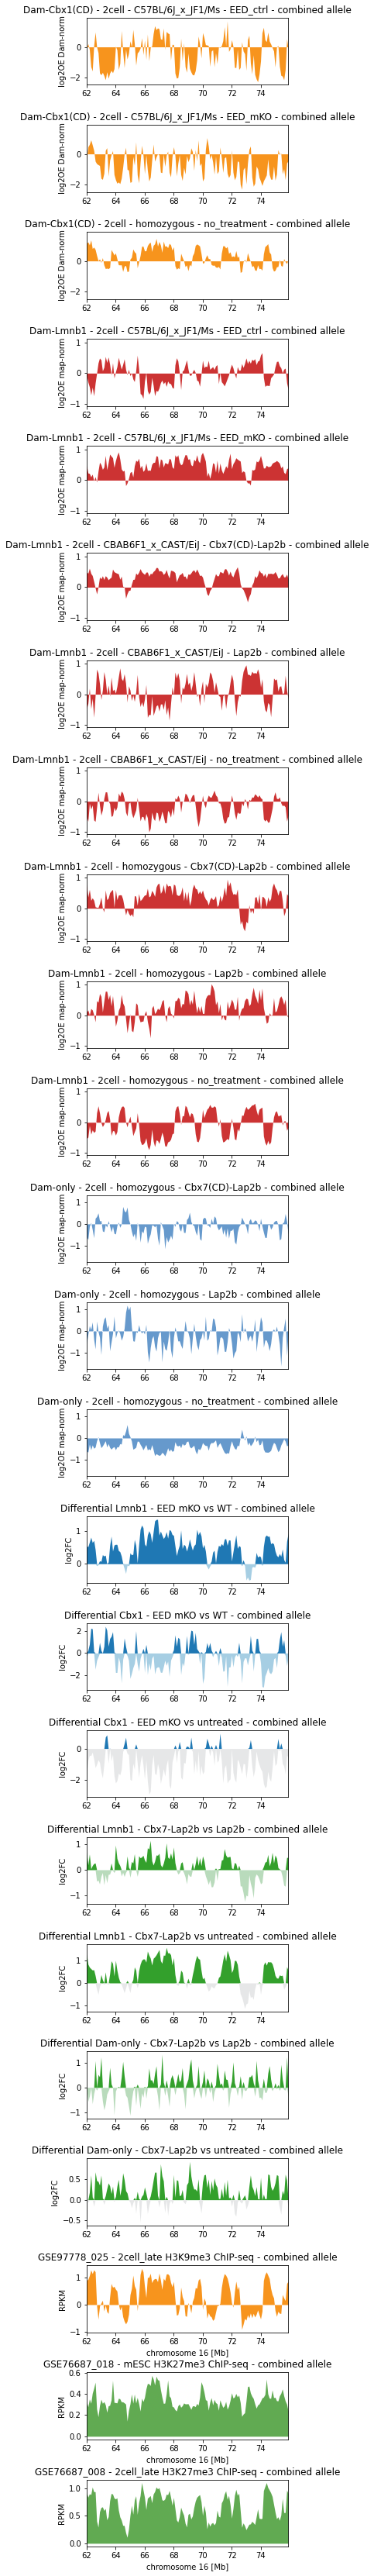

In [27]:
chrom = '16'
interval = [62e6,76e6]

if len(interval) == 2:
    FIGW = (interval[1]-interval[0])/3e6
    smooth_std=50000
else:
    FIGW = len(mapab[chrom]) / len(mapab['1']) * 10
    smooth_std=250000

alleles = ['combined']
ext_samples = ['GSE97778_025', 'GSE76687_018', 'GSE76687_008']
fig, axes = plot_tracks_with_differential_signal(
    chrom, alleles, interval=interval, smooth_std=smooth_std, figw=FIGW, ext_samples=ext_samples)
plt.show()

## 4.3 Saving regions of interest

In [28]:
regions_to_plot = [
    ['11', []],
    ['11', [103e6, 116e6]],
    ['13', []],
    ['13', [60e6,80e6]],
    ['16', []],
    ['16', [62e6,76e6]]
]

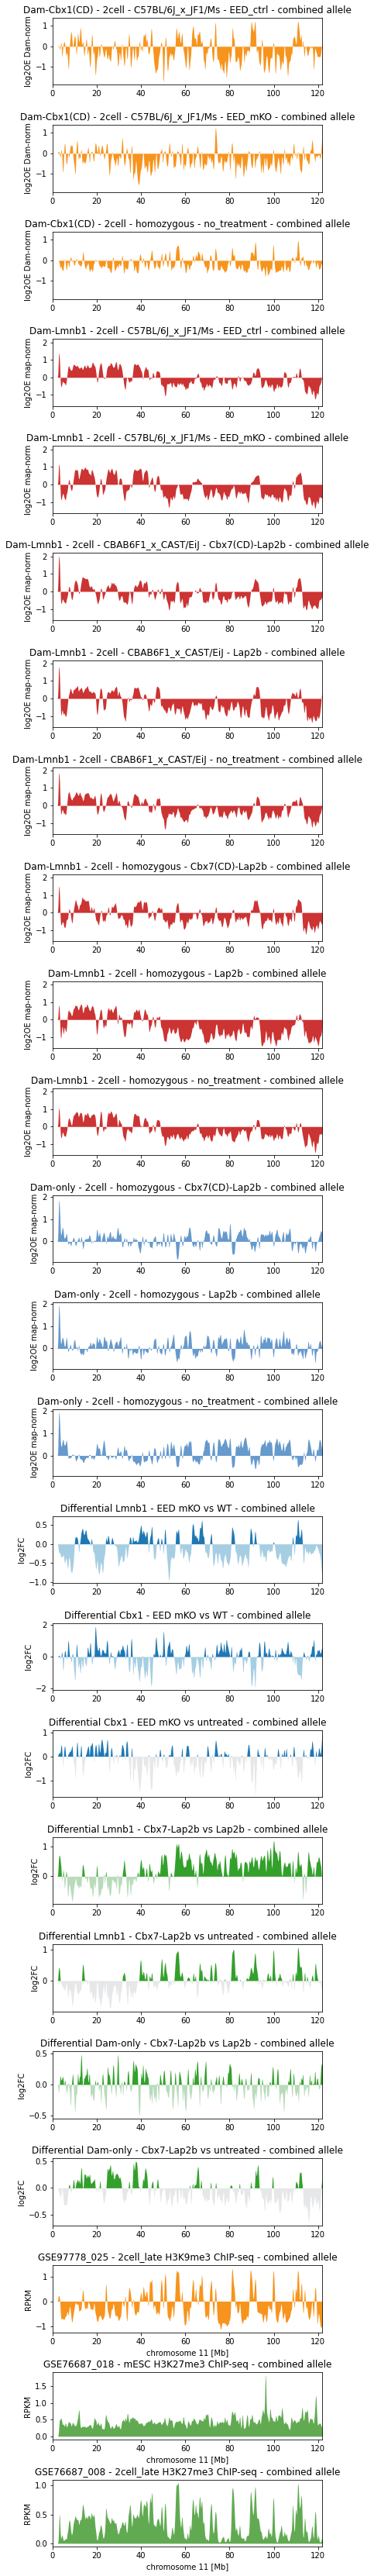

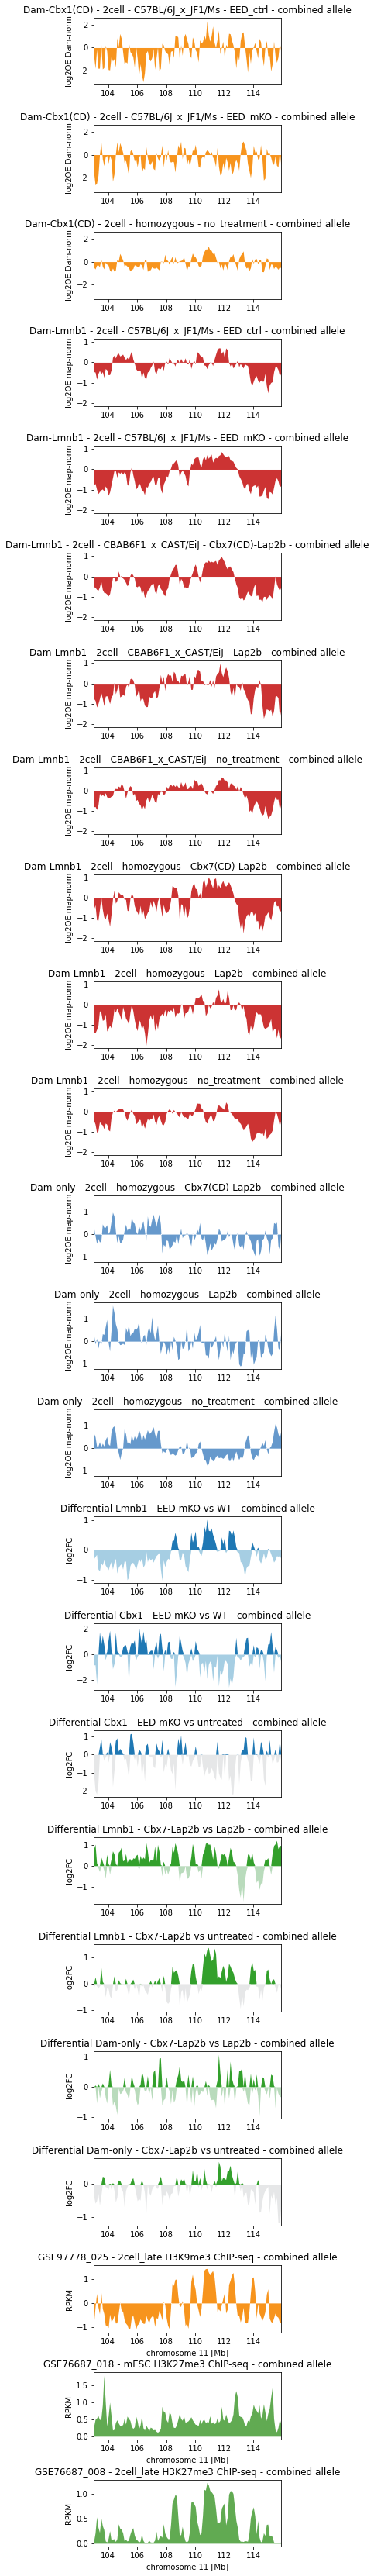

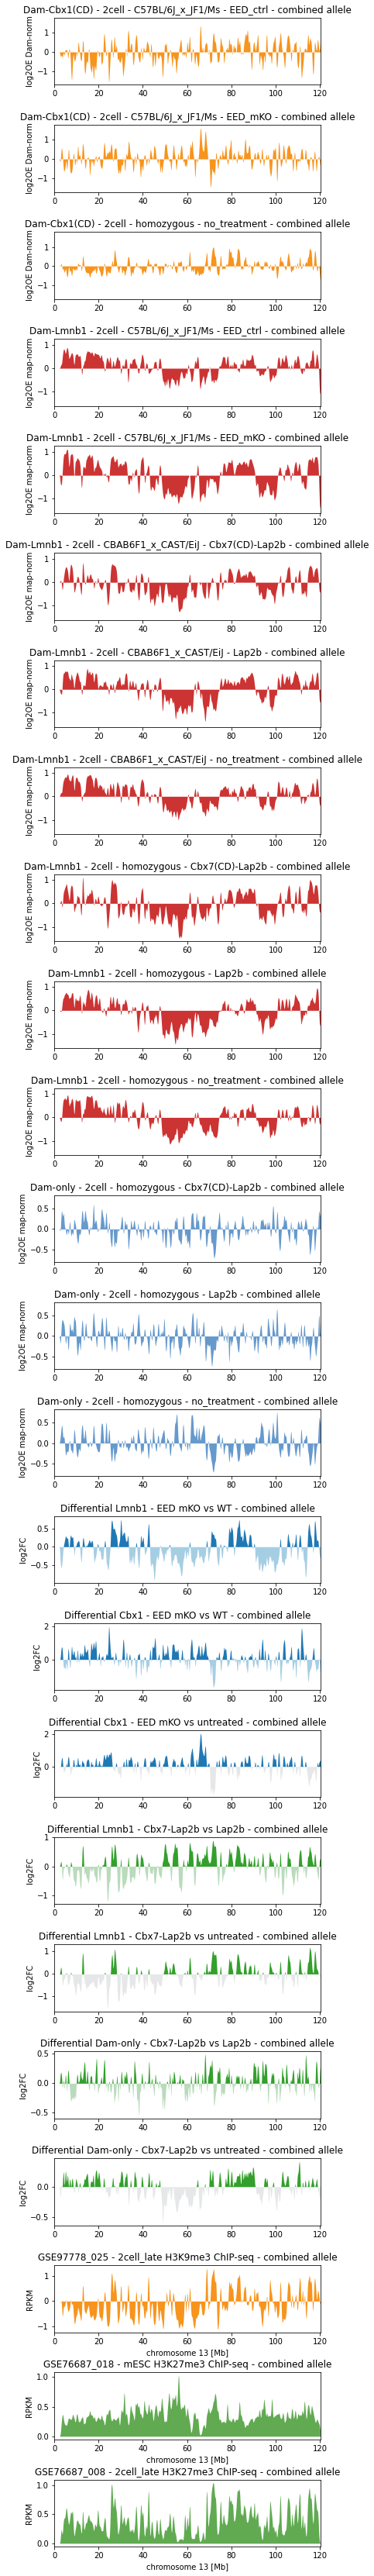

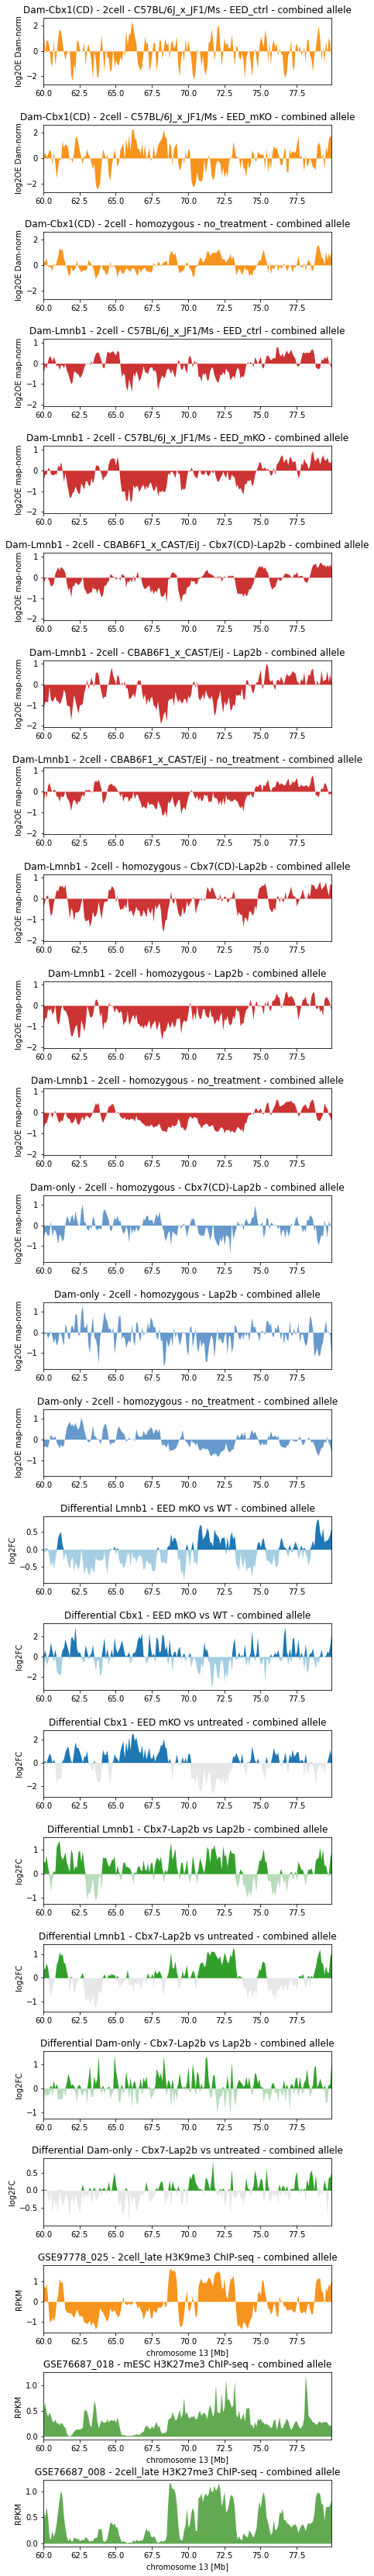

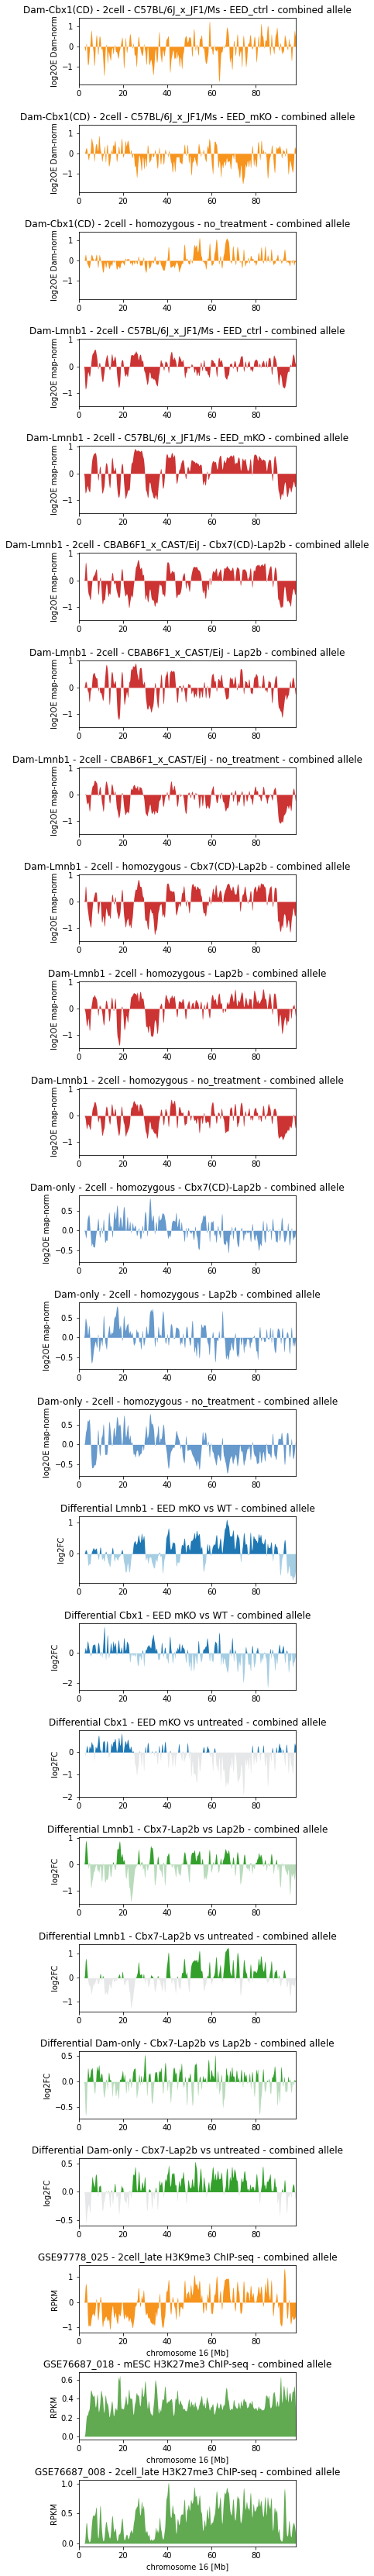

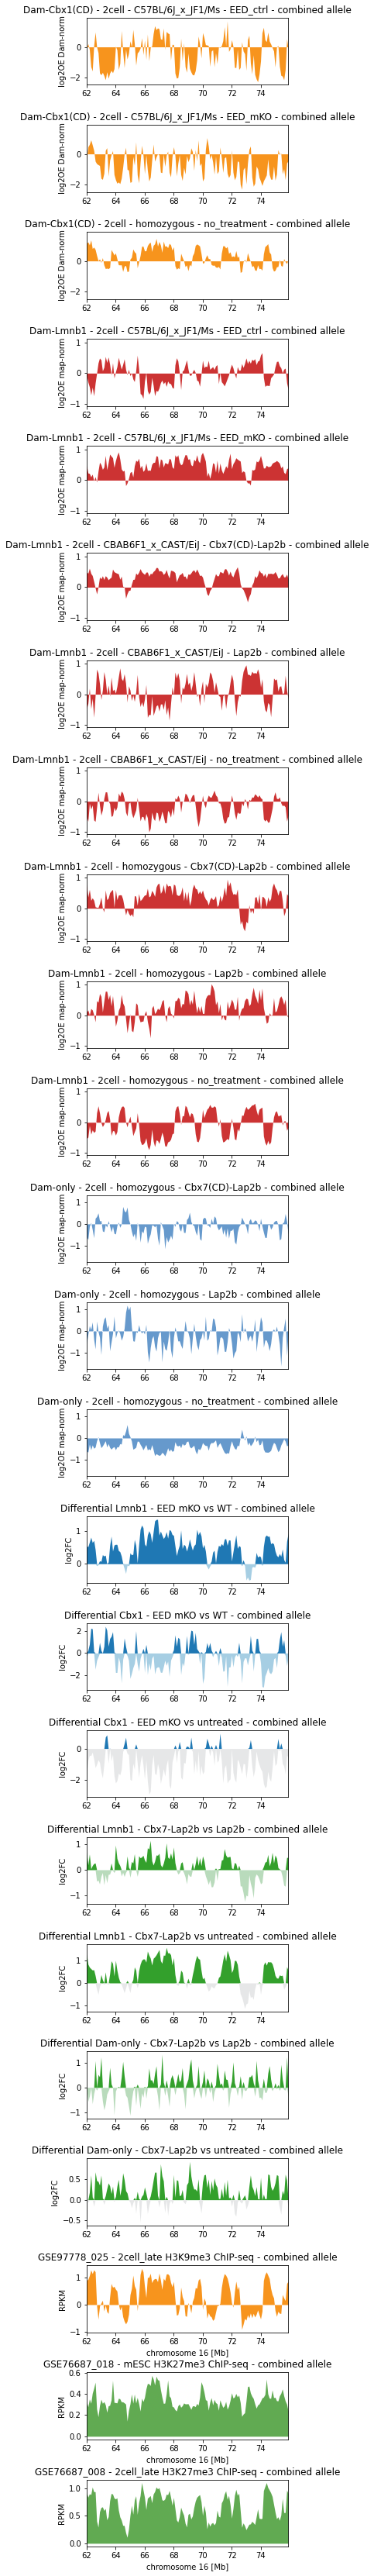

In [29]:
alleles = ['combined']
ext_samples = ['GSE97778_025', 'GSE76687_018', 'GSE76687_008']

for chrom, interval in regions_to_plot:
    
    if len(interval) == 2:
        FIGW = (interval[1]-interval[0])/3e6
        smooth_std=50000
        name = 'chr%s_%.0f_%.0f' % (chrom, interval[0], interval[1])
    else:
        FIGW = len(mapab[chrom]) / len(mapab['1']) * 10
        smooth_std=250000
        name = 'whole_chr%s' % chrom
        
    fig, axes = plot_tracks_with_differential_signal(
        chrom, alleles, interval=interval, smooth_std=smooth_std, 
        figw=FIGW, ext_samples=ext_samples
    )
    
    outfn = FIGOUTDIR + 'example_track.%s.pdf' % name
    plt.savefig(outfn, bbox_inches='tight')

# 5. Hexbin plots

## 5.1 Comparing Cbx1(CD) samples directly - EED mKO vs ctrl

In [30]:
import itertools

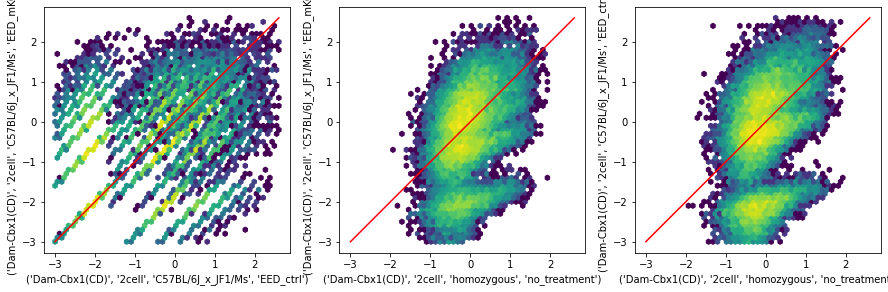

In [31]:
Sa = ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
Sb = ('Dam-Cbx1(CD)', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
Sc = ('Dam-Cbx1(CD)', '2cell', 'homozygous', 'no_treatment')

fig, axes = plt.subplots(1,3,figsize=(15,5))
counter = 0

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

for sample1, sample2 in itertools.combinations([Sa,Sb,Sc], 2):
    
    ax = axes[counter]
    counter += 1
    
    X = np.concatenate([damid_insilico_damnorm['combined'][sample2][c] for c in chrom_order[:-2]])[m_ind]
    Y = np.concatenate([damid_insilico_damnorm['combined'][sample1][c] for c in chrom_order[:-2]])[m_ind]
    
    ax.hexbin(X, Y, bins='log', extent=[-3,2.6,-3,2.6], gridsize=50)
    ax.set_xlabel(sample2)
    ax.set_ylabel(sample1)
    ax.set_aspect('equal')
    ax.plot([-3,2.6], [-3,2.6], c='r')

## 5.2 Projecting EED mKO vs ctrl effect of Cbx1 on Lmnb1 hexbin

In [32]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
top = mpl.colormaps['Greys_r'].resampled(128)
bottom = mpl.colormaps['Oranges'].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
OrangesGreys = ListedColormap(newcolors, name='OrangesGreys')


In [33]:
top = mpl.colormaps['Greys_r'].resampled(128)
bottom = mpl.colormaps['YlOrBr'].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
YlOrBrGreys = ListedColormap(newcolors, name='YlOrBrGreys')

In [34]:
top = mpl.colormaps['Greens_r'].resampled(128)
bottom = mpl.colormaps['Oranges'].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
OrangesGreens = ListedColormap(newcolors, name='OrangesGreens')


In [35]:
cmap_options = {
    'Grey-Orange': OrangesGreys,
    'Green-Blue-Brown': 'BrBG_r',
    'Grey-Yellow-Orange': YlOrBrGreys,
    'Green-Orange': OrangesGreens,
    'Purple-Orange': 'PuOr_r'
}

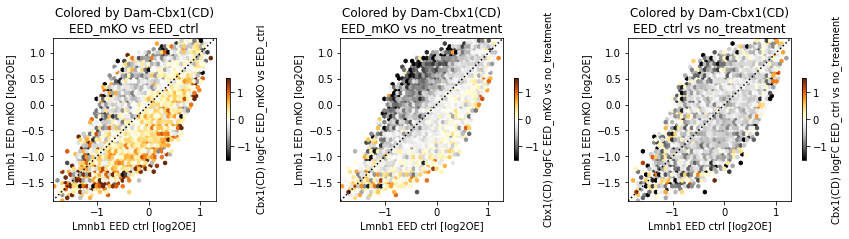

In [36]:
# prepare Lmnb1 data
Sd = ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
Se = ('Dam-Lmnb1', '2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl')
allele = 'combined'

filt_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
if allele != 'combined':
    a_ind = np.concatenate([allele_filt_gt[Sd[2]][c] for c in chrom_order[:-2]])
    filt_ind = filt_ind & a_ind

X = np.concatenate([damid_insilico_logoe[allele][Se][c] for c in chrom_order[:-2]])[filt_ind]
Y = np.concatenate([damid_insilico_logoe[allele][Sd][c] for c in chrom_order[:-2]])[filt_ind]
mn = min(np.percentile(X,0.1), np.percentile(Y,0.1))
mx = max(np.percentile(X,99.9), np.percentile(Y,99.9))

# figure set-up
for colorname, cmap in cmap_options.items():
    fig, axes = plt.subplots(1,3,figsize=(14,3))
    plt.subplots_adjust(wspace=.4)
    counter = 0

    # iterate over sample combinations and plot
    for sample1, sample2 in itertools.combinations([Sa,Sb,Sc], 2):

        ax = axes[counter]
        counter += 1

        S1 = np.concatenate([damid_insilico_damnorm['combined'][sample1][c] for c in chrom_order[:-2]])[filt_ind]
        S2 = np.concatenate([damid_insilico_damnorm['combined'][sample2][c] for c in chrom_order[:-2]])[filt_ind]
        FC = S1 - S2

        title = 'Colored by Dam-Cbx1(CD)\n%s vs %s' % (sample1[3], sample2[3])
        ax.set_title(title)

        p = ax.hexbin(X, Y, FC, extent=[mn,mx,mn,mx], gridsize=50, mincnt=1, cmap=cmap, vmin=-1.5, vmax=1.5)
        cbar = plt.colorbar(p, ax=ax, shrink=0.5)
        cbar.ax.set_ylabel('Cbx1(CD) logFC %s vs %s' % (sample1[3], sample2[3]))
        ax.set_xlabel('Lmnb1 EED ctrl [log2OE]')
        ax.set_ylabel('Lmnb1 EED mKO [log2OE]')
        ax.set_aspect('equal')
        ax.plot([mn,mx], [mn,mx], c='k', ls=':')
        ax.set_xlim([mn,mx])
        ax.set_ylim([mn,mx])
        
    outfn = FIGOUTDIR + 'hexbin.Lmnb1_EEDmKO_vs_WT.projection_of_Cbx1_EEDmKO_vs_WT.combined_alleles.colormap_%s.pdf' % colorname
    plt.savefig(outfn, bbox_inches='tight')
    
    if colorname == 'Grey-Yellow-Orange':
        plt.show()
    plt.close()
    

## 5.3 Comparing Dam-only Cbx7-Lap2b vs Lap2b

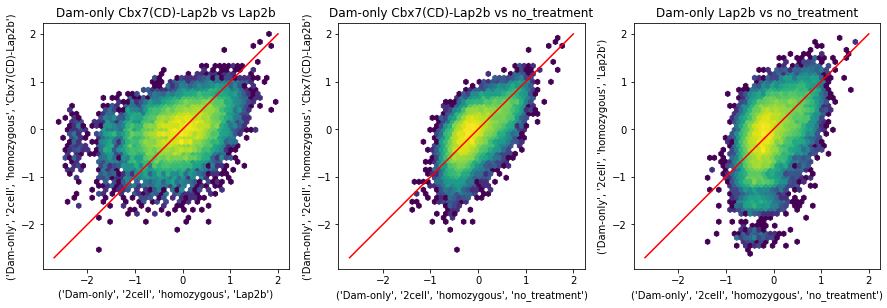

In [37]:
Sa = ('Dam-only', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
Sb = ('Dam-only', '2cell', 'homozygous', 'Lap2b')
Sc = ('Dam-only', '2cell', 'homozygous', 'no_treatment')

fig, axes = plt.subplots(1,3,figsize=(15,5))
counter = 0

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

for sample1, sample2 in itertools.combinations([Sa,Sb,Sc], 2):
    
    ax = axes[counter]
    counter += 1
    
    X = np.concatenate([damid_insilico_logoe['combined'][sample2][c] for c in chrom_order[:-2]])[m_ind]
    Y = np.concatenate([damid_insilico_logoe['combined'][sample1][c] for c in chrom_order[:-2]])[m_ind]
    
#     ax.hexbin(X, Y, bins='log', extent=[0,1.5,0,1.5], gridsize=20)
    ax.hexbin(X, Y, bins='log', extent=[-2.7,2,-2.7,2], gridsize=50)
    ax.set_xlabel(sample2)
    ax.set_ylabel(sample1)
    ax.set_aspect('equal')
    ax.plot([-2.7,2], [-2.7,2], c='r')
#     ax.plot([0,1.5], [0,1.5], c='r')
    ax.set_title('Dam-only %s vs %s' % (sample1[3], sample2[3]))

## 5.4 Projecting Cbx7-Lap2b vs Lap2b effect of Dam-only on Lmnb1 hexbin

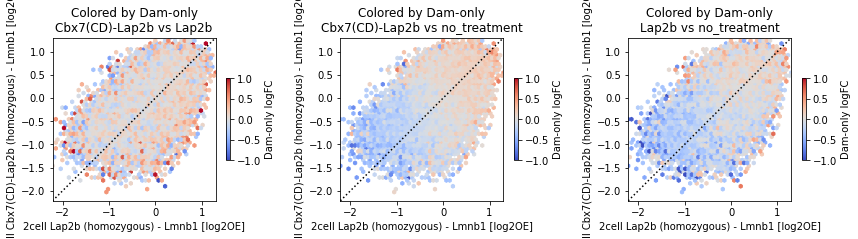

In [38]:
# prepare Lmnb1 data
Sd = ('Dam-Lmnb1', '2cell', 'homozygous', 'Cbx7(CD)-Lap2b')
Se = ('Dam-Lmnb1', '2cell', 'homozygous', 'Lap2b')
allele = 'combined'

filt_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
if allele != 'combined':
    a_ind = np.concatenate([allele_filt_gt[Sd[2]][c] for c in chrom_order[:-2]])
    filt_ind = filt_ind & a_ind

X = np.concatenate([damid_insilico_logoe[allele][Se][c] for c in chrom_order[:-2]])[filt_ind]
Y = np.concatenate([damid_insilico_logoe[allele][Sd][c] for c in chrom_order[:-2]])[filt_ind]
mn = min(np.percentile(X,0.1), np.percentile(Y,0.1))
mx = max(np.percentile(X,99.9), np.percentile(Y,99.9))

# figure set-up
fig, axes = plt.subplots(1,3,figsize=(14,3))
plt.subplots_adjust(wspace=.4)
counter = 0

# iterate over sample combinations and plot
for sample1, sample2 in itertools.combinations([Sa,Sb,Sc], 2):

    ax = axes[counter]
    counter += 1

    S1 = np.concatenate([damid_insilico_damnorm['combined'][sample1][c] for c in chrom_order[:-2]])[filt_ind]
    S2 = np.concatenate([damid_insilico_damnorm['combined'][sample2][c] for c in chrom_order[:-2]])[filt_ind]
    FC = S1 - S2

    title = 'Colored by Dam-only\n%s vs %s' % (sample1[3], sample2[3])
    ax.set_title(title)

    p = ax.hexbin(X, Y, FC, extent=[mn,mx,mn,mx], gridsize=50, mincnt=1, cmap='coolwarm', vmin=-1, vmax=1)
    cbar = plt.colorbar(p, ax=ax, shrink=0.5)
    cbar.ax.set_ylabel('Dam-only logFC')
    ax.set_xlabel('2cell Lap2b (homozygous) - Lmnb1 [log2OE]')
    ax.set_ylabel('2cell Cbx7(CD)-Lap2b (homozygous) - Lmnb1 [log2OE]')
    ax.set_aspect('equal')
    ax.plot([mn,mx], [mn,mx], c='k', ls=':')
    ax.set_xlim([mn,mx])
    ax.set_ylim([mn,mx])

outfn = FIGOUTDIR + 'hexbin.Lmnb1_Cbx7Lap2b_vs_Lap2b.projection_of_DamOnly_Cbx7Lap2b_vs_Lap2b.combined_alleles.pdf'
plt.savefig(outfn, bbox_inches='tight')

# 6. Confirm behaviour of individual cells

## 6.1 Collect H3K27me3 data

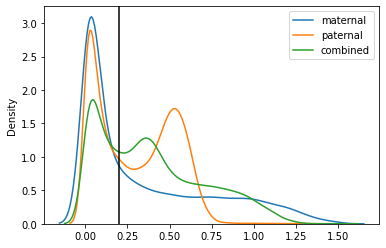

In [25]:
fig, ax = plt.subplots()

k27_level = dict()
ext_sample = 'GSE76687_008'

for allele in ['maternal', 'paternal', 'combined']:
    
    if allele == 'combined':
        C = np.concatenate([ext_data['combined'][ext_sample][c] for c in chrom_order[:-2]])
    else:
        C = np.concatenate([ext_data['%s_corrected'%allele][ext_sample][c] for c in chrom_order[:-2]])
        
    k27_level['H3K27me3_%s' % allele] = C
    sns.kdeplot(C.clip(0,1.5), label=allele)
    
ax.legend()
ax.axvline(0.2, c='k')
        
V = np.concatenate([ext_data['allele_vis'][ext_sample][c] for c in chrom_order[:-2]])
k27_level['is_vis_k27'] = (V > 0.1)
k27_level['is_vis_damid'] = np.concatenate([allele_filt_total[c] for c in chrom_order[:-2]])
k27_level['is_mapab'] = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP

k27_level = pd.DataFrame(k27_level)

In [26]:
k27_level[k27_level.is_vis_k27&k27_level.is_mapab].groupby(k27_level['H3K27me3_combined']>0.2).agg({'is_mapab': sum, 'H3K27me3_maternal': lambda c: np.mean(c>0.25), 'H3K27me3_paternal': lambda c: np.mean(c>0.25)})

is_mapab  H3K27me3_maternal  H3K27me3_paternal
H3K27me3_combined                                                
False                  7239           0.018373           0.049731
True                  15610           0.640231           0.785266

## 6.2 Collection fraction counts in H3K27me3-rich bins per sample

In [27]:
genotype_abbrev = {
    '129S1/SvImJ_x_CAST/EiJ': '129S1xCAST', 
    'CBAB6F1_x_CAST/EiJ': 'F1xCAST', 
    'C57BL/6J_x_JF1/Ms': 'BL6xJF1',
    'homozygous': 'homoz'
}

In [28]:
to_plot = list()

for allele in ['maternal', 'paternal', 'combined']:

    ind_valid = (k27_level['is_vis_k27'] & k27_level['is_mapab']).values
    if allele != 'combined':
        ind_valid = ind_valid & k27_level['is_vis_damid'].values
        
    has_k27 = ind_valid & (k27_level['H3K27me3_%s' % allele].values > 0.2)

    for sample, row in anno.iterrows():

        if sample not in damid_counts[allele]:
            continue
        C = np.concatenate([damid_counts[allele][sample][c] for c in chrom_order[:-2]])
        f = C[has_k27].sum() / C[ind_valid].sum()

        to_plot.append( [allele, sample, row['fusion_construct'], row['stage'], row['genotype'], row['treatment'], f] )

to_plot = pd.DataFrame(to_plot, columns=['allele', 'sample', 'fusion_construct', 'stage', 'genotype', 'treatment', 'fraction'])

make_label = lambda r: '%s\n%s\n%s\n%s' % (r['fusion_construct'], r['stage'], genotype_abbrev[r['genotype']], r['treatment'])
to_plot['label'] = to_plot.apply(axis=1, func = make_label)
to_plot['stage'] = pd.Categorical(to_plot['stage'], categories=stage_order)
to_plot['treatment'] = pd.Categorical(to_plot['treatment'], categories=treatment_order)

## Function to plot results

In [29]:
def plot_fraction_counts(select_ind):
    
    order = to_plot[select_ind].sort_values(by=['fusion_construct','stage','genotype','treatment'])['label'].unique()
    figw = len(order)
    
    fig, axes = plt.subplots(3,1,figsize=(figw,14))
    plt.subplots_adjust(hspace=.7)

    
    construct = to_plot.loc[select_ind,'fusion_construct'].unique()
    assert len(construct) == 1
    construct = construct[0]
    
    for irow, allele in enumerate(['combined', 'maternal', 'paternal']):
        ax = axes[irow]

        ind = select_ind & (to_plot['allele'] == allele)
        if ind.sum() == 0:
            ax.remove()
            continue

        sns.boxplot(
            data=to_plot[ind], 
            x='label', y='fraction', order=order,
            ax=ax, color='white', fliersize=0
        )
        sns.stripplot(
            data=to_plot[ind], 
            x='label', y='fraction', order=order,
            ax=ax
        )

        ax.set_ylabel('fraction')
        ax.set_title('fraction of %s %s scDamID counts\nin H3K27me3 rich bins (%s RPKM > 0.2)' % (construct, allele, allele))


## 6.3 Results all 2-cell Lmnb1 samples

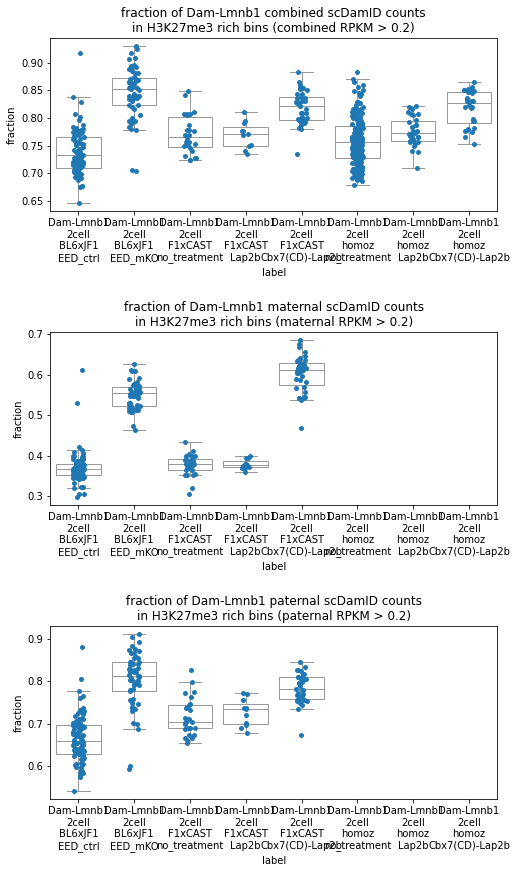

In [30]:
select_ind = (to_plot['fusion_construct']=='Dam-Lmnb1') & (to_plot['stage'] == '2cell')
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.2cell_Lmnb1.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 6.4 Results all Cbx7-Lap2b Lmnb1 conditions

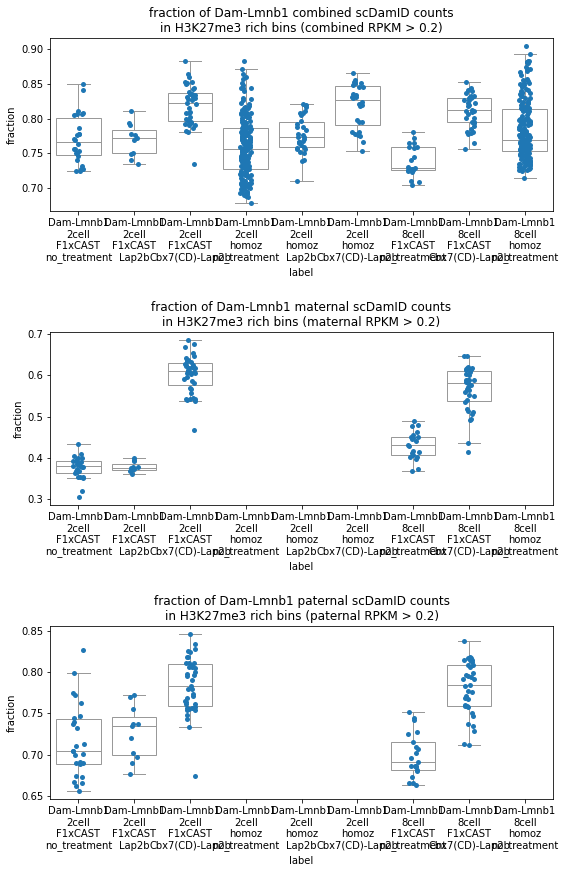

In [31]:
select_ind = (to_plot['fusion_construct']=='Dam-Lmnb1') & to_plot['stage'].isin(['2cell','8cell']) & to_plot['treatment'].isin(['no_treatment', 'Lap2b', 'Cbx7(CD)-Lap2b'])
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.2cell_8cell_Cbx7-Lap2b_Lmnb1.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 6.5 Results all untreated Lmnb1 samples

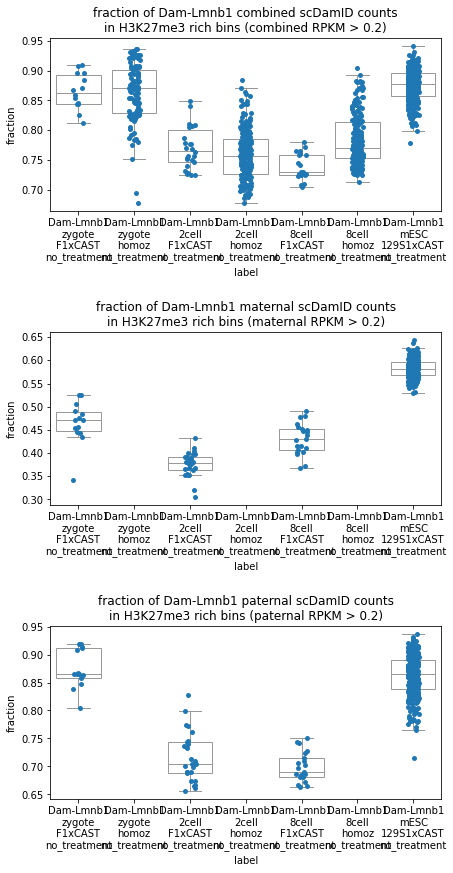

In [32]:
select_ind = (to_plot['fusion_construct']=='Dam-Lmnb1') & (to_plot['treatment'] == 'no_treatment')
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.untreated_Lmnb1.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 6.5 Results all Cbx1(CD) samples

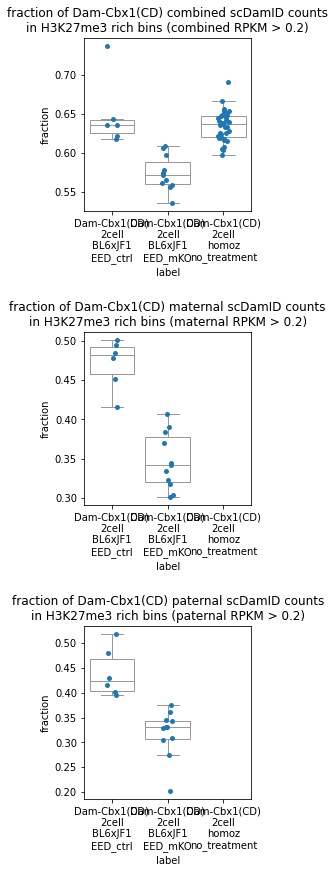

In [33]:
select_ind = (to_plot['fusion_construct']=='Dam-Cbx1(CD)')
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.Cbx1.pdf'
plt.savefig(outfn, bbox_inches='tight')

## 6.5 Results all Dam-only samples

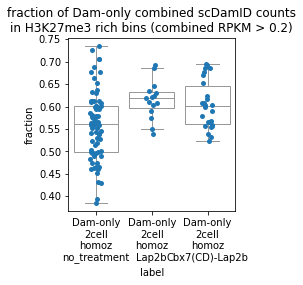

In [34]:
select_ind = (to_plot['fusion_construct']=='Dam-only')
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.DamOnly.pdf'
plt.savefig(outfn, bbox_inches='tight')

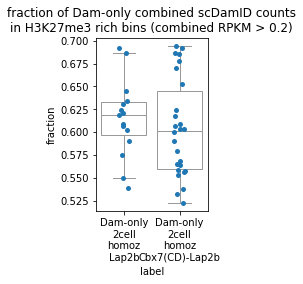

In [35]:
select_ind = (to_plot['fusion_construct']=='Dam-only') & (to_plot['treatment'] != 'no_treatment')
plot_fraction_counts(select_ind)

outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.DamOnly_Lap2b_vs_Cbx7Lap2b.pdf'
plt.savefig(outfn, bbox_inches='tight')

## Statistical test between treatment conditions

In [50]:
stat_df = defaultdict(list)
assert len(to_plot['stage'])

for (construct, allele), df in to_plot.groupby(['fusion_construct','allele']):
    
    conditions = [info for info, _ in df.groupby(['stage', 'genotype', 'treatment'])]
    
    if construct == 'Dam-Cbx1(CD)':
        print(list(itertools.combinations(conditions,2)))
    
    for sample1, sample2 in itertools.combinations(conditions,2):
        
        if construct == 'Dam-Cbx1(CD)':
            print(allele, sample1, sample2)
        
        # only do the comparison when only 1 sample feature differs
        ndiff = (np.array(sample1) != np.array(sample2)).sum()
        if (ndiff > 1) and (construct != 'Dam-Cbx1(CD)'):
            continue
        # if the one different feature is genotype, continue
        if (sample1[1] != sample2[1]) and (construct != 'Dam-Cbx1(CD)'):
            continue
            
        print('yes')
        
        stat_df['allele'].append(allele)
        stat_df['fusion_construct'].append(construct)
        vals = dict()
        
        for i, sample in enumerate([sample1, sample2]):
            i += 1
            stat_df['stage_%d' % i].append(sample[0])
            stat_df['genotype_%d' % i].append(sample[1])
            stat_df['treatment_%d' % i].append(sample[2])
            
            ind = (df['stage']==sample[0]) & (df['genotype']==sample[1]) & (df['treatment']==sample[2])
            stat_df['n_cells_%d' % i].append(ind.sum())
            
            X = df.loc[ind,'fraction'].values
            stat_df['mean_%d' % i].append(np.mean(X))
            stat_df['median_%d' % i].append(np.median(X))
            stat_df['std_%d' % i].append(np.std(X))
            
            vals[i] = X
            
        s, p = stats.mannwhitneyu(vals[1], vals[2])
        stat_df['MWU_statistic'].append(s)
        stat_df['MWU_pvalue'].append(p)
        
stat_df = pd.DataFrame(stat_df)

[(('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')), (('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'homozygous', 'no_treatment')), (('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'), ('2cell', 'homozygous', 'no_treatment'))]
combined ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
yes
combined ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') ('2cell', 'homozygous', 'no_treatment')
yes
combined ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO') ('2cell', 'homozygous', 'no_treatment')
yes
[(('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'))]
maternal ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
yes
[(('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl'), ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO'))]
paternal ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_ctrl') ('2cell', 'C57BL/6J_x_JF1/Ms', 'EED_mKO')
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [51]:
stat_df[(stat_df.fusion_construct=='Dam-Cbx1(CD)')]

allele fusion_construct stage_1         genotype_1 treatment_1  \
0  combined     Dam-Cbx1(CD)   2cell  C57BL/6J_x_JF1/Ms    EED_ctrl   
1  combined     Dam-Cbx1(CD)   2cell  C57BL/6J_x_JF1/Ms    EED_ctrl   
2  combined     Dam-Cbx1(CD)   2cell  C57BL/6J_x_JF1/Ms     EED_mKO   
3  maternal     Dam-Cbx1(CD)   2cell  C57BL/6J_x_JF1/Ms    EED_ctrl   
4  paternal     Dam-Cbx1(CD)   2cell  C57BL/6J_x_JF1/Ms    EED_ctrl   

   n_cells_1    mean_1  median_1     std_1 stage_2         genotype_2  \
0          6  0.648888  0.636180  0.040626   2cell  C57BL/6J_x_JF1/Ms   
1          6  0.648888  0.636180  0.040626   2cell         homozygous   
2         11  0.573757  0.571210  0.021580   2cell         homozygous   
3          6  0.471232  0.481717  0.029448   2cell  C57BL/6J_x_JF1/Ms   
4          6  0.440000  0.422588  0.044571   2cell  C57BL/6J_x_JF1/Ms   

    treatment_2  n_cells_2    mean_2  median_2     std_2  MWU_statistic  \
0       EED_mKO         11  0.573757  0.571210  0.021580           66.0   
1  no_treatment         37  0.634577  0.636469  0.018823          116.0   
2  no_treatment         37  0.634577  0.636469  0.018823            8.0   
3       EED_mKO         11  0.347161  0.341420  0.034644           66.0   
4       EED_mKO         11  0.318917  0.331373  0.045144           66.0   

   MWU_pvalue  
0    0.000162  
1    0.877857  
2    0.000002  
3    0.000162  
4    0.000162

In [52]:
outfn = FIGOUTDIR + 'fraction_of_scDamID_counts_in_H3K27me3_bins.stat_results.tsv.gz'
stat_df.to_csv(outfn, sep='\t', header=True, index=False)